In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"

# Libraries and Imports

In [2]:
import editdistance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from llms.dna_translator.gpt import DNATranslatorGPT
from schemas.train_params import TrainParams

# Params and Files

In [3]:
seed = 42

csv_path = "tran-1000.csv"
pretrained_model_name = "DNATranGPT"

In [4]:
csv_path = f"./storage/data/processed/{csv_path}"
output_path = f"./storage/models/tuned/{pretrained_model_name}"
checkpoint = "./storage/models/base/gpt2"

# Reading Dataset

In [5]:
df = pd.read_csv(csv_path, keep_default_na=False)

# Loading Model

In [6]:
llm = DNATranslatorGPT(
  checkpoint=checkpoint,
  seed=seed
)

# Data Processing

In [7]:
data = df.to_dict(orient="records")

In [8]:
all_dataset = []
for record in tqdm(data):
  example = llm.build_input(
    dna_sequence=record["sequence"],
    organism=record["organism"],
    protein_sequence=record["target"]
	)
  all_dataset.append(example)

train_dataset, test_dataset = train_test_split(
  all_dataset,
  test_size=0.05,
  random_state=seed,
  shuffle=True
)

100%|██████████| 244090/244090 [00:00<00:00, 1818224.49it/s]


# Data Analysis

In [9]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

Train Dataset Len: 231885
Test Dataset Len: 12205


In [10]:
train_lengths = [len(example["dna_sequence"]) for example in train_dataset]
test_lengths = [len(example["dna_sequence"]) for example in test_dataset]

Train Dataset Len: 231885
Test Dataset Len: 12205


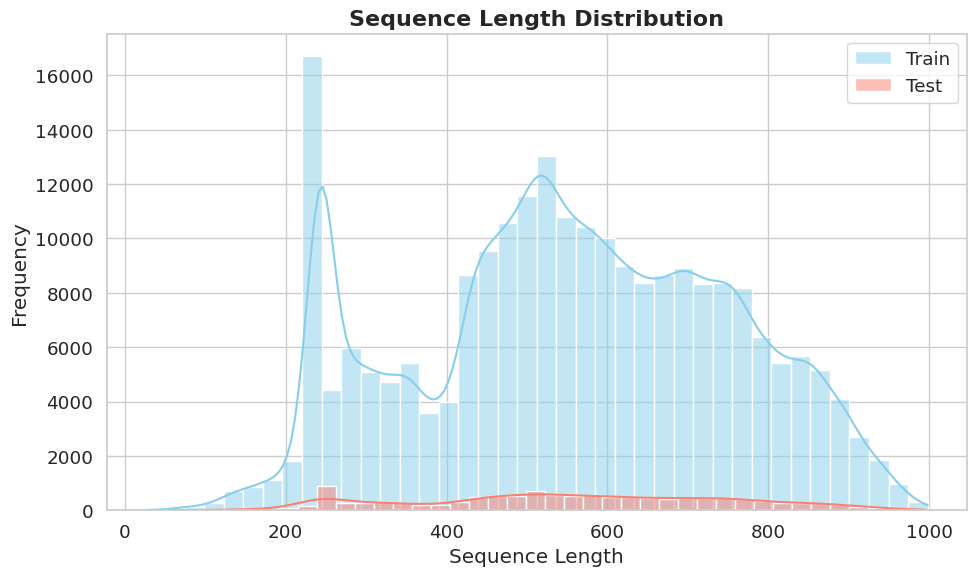

In [11]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, kde=True, bins=40, color="skyblue", label="Train")
sns.histplot(test_lengths, kde=True, bins=40, color="salmon", label="Test")

plt.title("Sequence Length Distribution", fontsize=16, weight="bold")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [12]:
llm.train(
  dataset=train_dataset,
  params=TrainParams(
    epochs=5,
    batch_size=16,
    gradient_accumulation=1,
    lr=4e-5,
    logging_steps=1000
	)
)

2025-12-02 17:12:28,963 - INFO - Preparing dataset...
100%|██████████| 231885/231885 [12:25<00:00, 311.05it/s]
2025-12-02 17:25:16,692 - INFO - Dataset prepared!
2025-12-02 17:25:20,101 - INFO - Starting training...
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1000,1.461700
2000,1.388800
3000,1.370000
4000,1.361200
5000,1.343300
6000,1.335200
7000,1.327600
8000,1.304800
9000,1.300200
10000,1.299000


2025-12-02 21:48:37,029 - INFO - Training complete. You may save the model for later usage.


# Saving The Model

In [13]:
llm.save_pretrained(output_path)

2025-12-02 21:48:37,167 - INFO - Attempting to save model at './storage/models/tuned/DNATranGPT'
2025-12-02 21:48:42,002 - INFO - Successfully saved at './storage/models/tuned/DNATranGPT'


# Test Without Blast

In [14]:
results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	#blast_results = blast_analysis(
	#	pred=pred,
	#	target=target
	#)

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity,
		#**blast_results
	})

100%|██████████| 12205/12205 [10:04:36<00:00,  2.97s/it] 


In [15]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

Mean similarity: 0.1034 ± 0.0740
